In [75]:
import shm_kmer_model_estimator.standard_model_estimations as standard_model_estimations

In [76]:
igh_model = standard_model_estimations.full_igh_model()

In [77]:
igh_model = igh_model['NoKNeighbours']['IGH']

In [78]:
igh_model.expect_subst_prob('AAAAA', 'C')

0.16456652442773134

In [79]:
import kmer_utilities.kmer_utilities as kmer_utilities

In [80]:
kmers = kmer_utilities.kmer_names()

In [131]:
mutation_ratios = []
for kmer in kmers:
    bases = list('ACGT')
    cent_ind = len(kmer) / 2
    cent_nucl = kmer[cent_ind]
    bases.remove(kmer[cent_ind])
    for base in bases:
        mut_kmer = list(kmer)
        mut_kmer[cent_ind] = base
        mut_kmer = ''.join(mut_kmer)
        forward_mut_prob = igh_model.expect_subst_prob(kmer, base)
        backward_mut_prob = igh_model.expect_subst_prob(mut_kmer, cent_nucl)
        
        mutation_ratio = forward_mut_prob / backward_mut_prob
        if mutation_ratio < 1:
            mutation_ratio = 1. / mutation_ratio
        mutation_ratios.append(mutation_ratio)

In [132]:
mutation_ratios = np.array(mutation_ratios)

In [133]:
mutation_ratios = mutation_ratios[~np.isnan(mutation_ratios)]
mutation_ratios = np.array(list(set(mutation_ratios)))

In [135]:
mutation_ratios = mutation_ratios[mutation_ratios <= 8]

In [136]:
import seaborn
%matplotlib inline

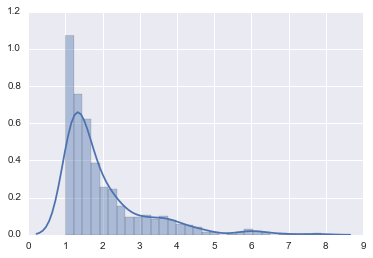

In [137]:
seaborn.distplot(mutation_ratios)

In [148]:
import sample_reader.standard_samples as standard_samples
import pandas as pd

In [149]:
samples = standard_samples.concatenate_kmer_freq_matrices()

In [165]:
np.array(samples.loc[:, 'AAAAA', 'T'] / samples.loc[:, 'AAAAA', ['G', 'C', 'T']].sum())

array([ 0.20754717,  0.10526316,  0.15      ,  0.0952381 ,  0.24873096,
        0.0625    ,  0.04347826,  0.03225806,  0.03703704,  0.01123596,
        0.07751938,  0.07194245,  0.02307692,  0.01052632,  0.01724138,
        0.        ,  0.02803738,  0.13829787,  0.03378378,  0.03508772,
        0.02542373,  0.20895522,  0.12121212,  0.        ,  0.04347826,
        0.09090909,  0.1147541 ,  0.08411215,  0.07038123,  0.10588235,
        0.13043478,  0.15254237,  0.04040404,  0.09467456,  0.08490566,
        0.09009009,  0.06944444,  0.16571429])

In [206]:
from scipy.stats import mannwhitneyu, ttest_ind
pvalues = []
for kmer in kmers:
    bases = list('ACGT')
    cent_ind = len(kmer) / 2
    cent_nucl = kmer[cent_ind]
    bases.remove(kmer[cent_ind])
    for base in bases:
        backward_bases = list('ACGT')
        backward_bases.remove(base)
        mut_kmer = list(kmer)
        mut_kmer[cent_ind] = base
        mut_kmer = ''.join(mut_kmer)

        forward_sum = np.array(samples.loc[:, kmer, bases].sum())
        backward_sum = np.array(samples.loc[:, mut_kmer, backward_bases].sum())
        if min(np.median(samples.loc[:, kmer, base]), np.median(samples.loc[:, mut_kmer, cent_nucl])) <= 20:
            continue

        forward_sample  = np.array(samples.loc[:, kmer, base] / forward_sum)
        backward_sample = np.array(samples.loc[:, mut_kmer, cent_nucl] / backward_sum)
        pvalues.append(mannwhitneyu(forward_sample, backward_sample).pvalue)

In [207]:
len(pvalues)

456

In [208]:
sign_level = 0.05
np.mean(np.array(pvalues) < sign_level / len(pvalues))

0.59210526315789469